## Check bulk density

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tramp.ensembles import GaussianEnsemble, MarchenkoPasturEnsemble
from tramp.experiments import run_experiments, qplot

In [2]:
from numpy.linalg import eigvalsh
def compare_spectrum(N, alpha):
    M = int(alpha*N)
    F = GaussianEnsemble(M, N).generate()
    C = F.T @ F
    spectrum = eigvalsh(C)
    bulk_spectrum = spectrum[spectrum>1e-11]
    plt.hist(bulk_spectrum, bins=50, density=True, label=f"empirical {alpha}", alpha=0.2)
    MP = MarchenkoPasturEnsemble(alpha)
    z = np.linspace(MP.z_min, MP.z_max, 100)
    density = MP.bulk_density(z)
    if alpha<1:
        density /= alpha
    plt.plot(z, density, label=f"MP {alpha}")
    plt.legend()

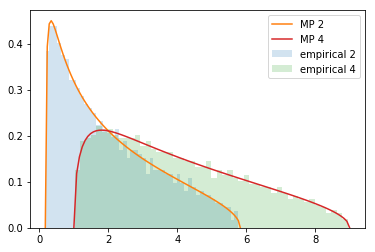

In [3]:
compare_spectrum(1000, 2)
compare_spectrum(1000, 4)


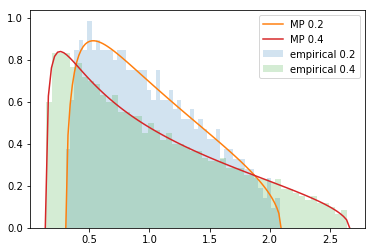

In [4]:
compare_spectrum(3000, 0.2)
compare_spectrum(3000, 0.4)

## Check eta and shannon transforms

In [5]:
def compare(N, alpha, gamma):
    M = int(alpha*N)
    F = GaussianEnsemble(M, N).generate()
    C = F.T @ F
    spectrum = eigvalsh(C)
    bulk_spectrum = spectrum[spectrum>1e-11]
    p0 = (spectrum<1e-11).mean()
    eta = 1/(1 + gamma*spectrum)
    shannon = np.log(1 + gamma*spectrum)
    MP = MarchenkoPasturEnsemble(alpha)
    delta = lambda z: 1*(z==0)
    result={
        "p0_emp":p0,
        "p0_th":MP.measure(delta),
        "z_min_emp":bulk_spectrum.min(), 
        "z_max_emp":bulk_spectrum.max(),
        "mean_emp":spectrum.mean(),
        "eta_emp":eta.mean(),
        "shannon_emp":shannon.mean(),
        "z_min_th":MP.z_min, 
        "z_max_th":MP.z_max,
        "mean_th":MP.mean_spectrum,
        "eta_th":MP.eta_transform(gamma),
        "shannon_th":MP.shannon_transform(gamma)
    }
    return result

In [6]:
df = run_experiments(compare, N=1000, alpha=np.linspace(0,4,50)[1:], gamma=1)

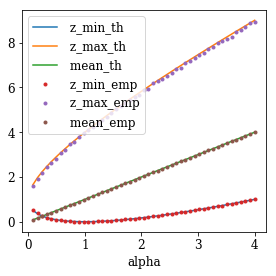

In [7]:
qplot(
    df, 
    x="alpha", 
    y=["z_min_th","z_max_th", "mean_th", "z_min_emp","z_max_emp", "mean_emp"], 
    y_markers=["-","-","-",".",".","."], y_legend=True
)

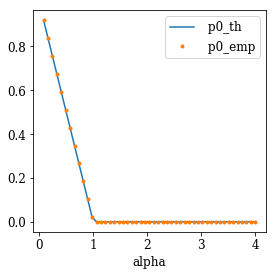

In [8]:
qplot(
    df, 
    x="alpha", 
    y=["p0_th","p0_emp"], 
    y_markers=["-","."], y_legend=True
)

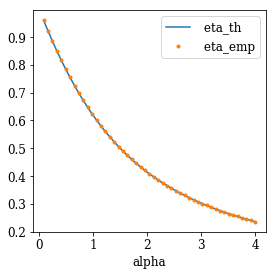

In [9]:
qplot(
    df, x="alpha", y=["eta_th","eta_emp"], 
    y_markers=["-","."], y_legend=True
)

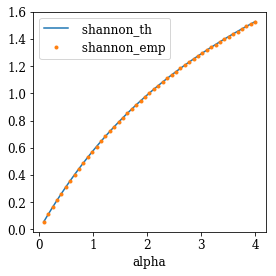

In [10]:
qplot(
    df, x="alpha", y=["shannon_th","shannon_emp"], 
    y_markers=["-","."], y_legend=True
)

## Compare linear channel and marchenko pastur

In [11]:
from tramp.channels import MarchenkoPasturChannel

def run_error(alpha, ax, az):
    channel = MarchenkoPasturChannel(alpha)
    n_eff = channel.compute_n_eff(az, ax)
    tau=1
    vz = channel.compute_backward_error(az, ax, tau)
    vx = channel.compute_forward_error(az, ax, tau)
    result = dict(
        vz=vz, vx=vx,
        vz_scaled=az*vz, vx_scaled=ax*vx,
        n_eff=n_eff
    )
    return result

wrt_alpha_th = run_experiments(
    run_error, alpha=10**np.linspace(-2, 1., 51), az=1., ax=[0.3, 1., 10.]
)
wrt_alpha_th["source"]="Marchenko Pastur"
wrt_alpha_emp = pd.read_csv("channel_linear_error_wrt_alpha.csv")
wrt_alpha_emp["source"]="empirical"
wrt_alpha = wrt_alpha_th.append(wrt_alpha_emp, ignore_index=True, sort=False)

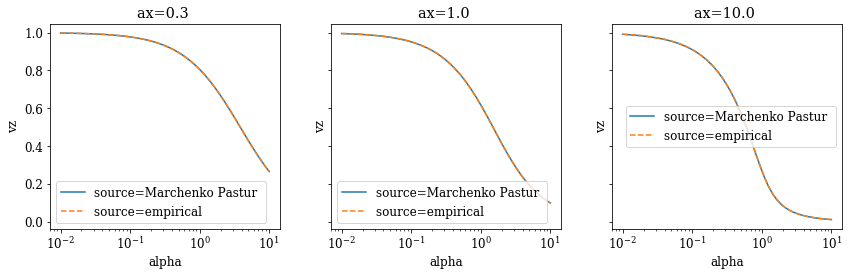

In [12]:
qplot(wrt_alpha, x="alpha", y="vz", linestyle="source", column="ax", xlog=True)

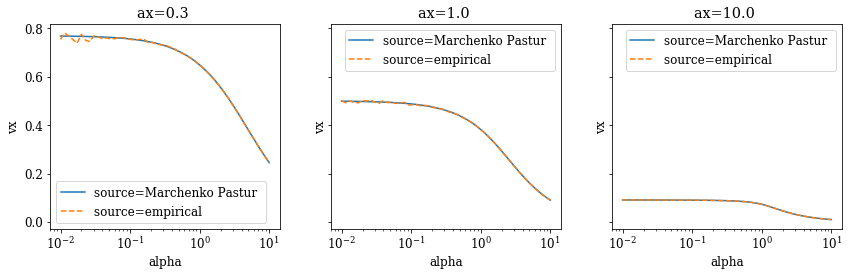

In [13]:
qplot(wrt_alpha, x="alpha", y="vx", linestyle="source", column="ax", xlog=True)

In [14]:
wrt_ax_th = run_experiments(
    run_error, alpha=[0.3, 1.0, 3.], az=1., ax=10**np.linspace(-3, 3, 51)
)
wrt_ax_th["source"]="Marchenko Pastur"
wrt_ax_emp = pd.read_csv("channel_linear_error_wrt_ax.csv")
wrt_ax_emp["source"]="empirical"
wrt_ax = wrt_ax_th.append(wrt_ax_emp, ignore_index=True, sort=False)

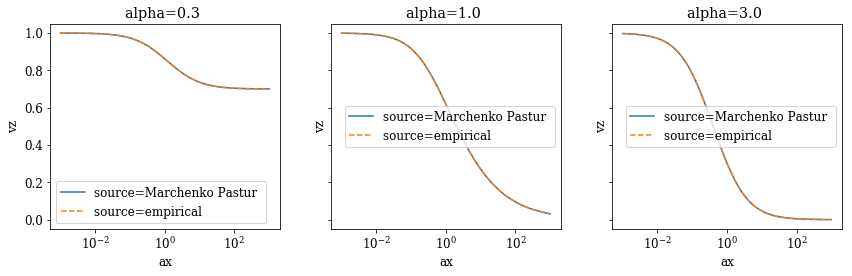

In [15]:
qplot(wrt_ax, x="ax", y="vz", linestyle="source", column="alpha", xlog=True)

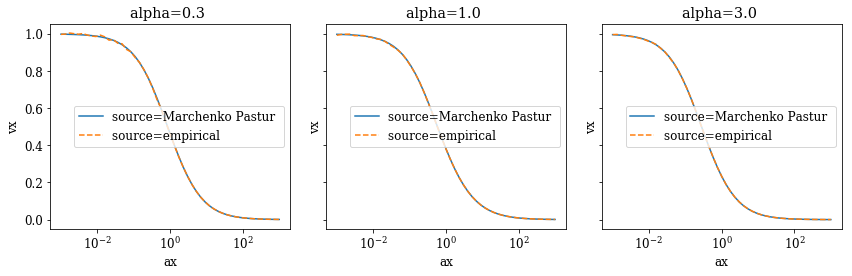

In [16]:
qplot(wrt_ax, x="ax", y="vx", linestyle="source", column="alpha", xlog=True)